# Uploading the Data

In [0]:
# mount drive
# data from http://vision.stanford.edu/aditya86/ImageNetDogs/
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# untar data files into /content/data/
!mkdir '/content/data'
!tar -C '/content/data' -xf '/content/gdrive/My Drive/computer vision project/images.tar'
!tar -C '/content/data' -xf '/content/gdrive/My Drive/computer vision project/annotation.tar'


# Defining a Custom Dataset

Includes loading data using dataset and splitting into training/validation. An example image is shown along with its corresponding class.

In [0]:
import os
import torch
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image


class dog_data(Dataset):

  def __init__(self, path, transform):
    self.x, self.y = [], []
    self.transform = transform
    for i, breed in enumerate(os.listdir(path)):
      for num, file in enumerate(os.listdir(path + '/' + breed)):
        annot_path = './data/Annotation/'+breed + '/' + file[:-4]
        bbox = bounding_box(file, annot_path)
        img = Image.open(path + '/' + breed + '/' + file).crop(bbox)
        self.x.append(img)
        self.y.append(i)
    self.y = torch.tensor(self.y, dtype=torch.long)


  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    img = self.x[index].convert('RGB')
    img = self.transform(img)
    return img, self.y[index]

# function bounding_box adapted from https://www.kaggle.com/whizzkid/crop-images-using-bounding-box
# it crops to the bounding box of the object we want to focus on
def bounding_box(image, path):
    tree = ET.parse(path)
    root = tree.getroot()
    objects = root.findall('object')
    for o in objects:
        bndbox = o.find('bndbox') # reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
    return (xmin,ymin,xmax,ymax)

breeds = ['']*120
path = './data/Images'
for i, breed in enumerate(os.listdir(path)):
  breeds[i] = breed[breed.find('-')+1:]

preprocess = transforms.Compose(
  [ 
    transforms.Resize((200, 200), interpolation=1),
    transforms.ToTensor()
    ])

all_data_normal = dog_data('./data/Images', preprocess)

num_train = int(0.8 * len(all_data_normal))
num_validation = len(all_data_normal) - num_train
training_data, validation_data = torch.utils.data.random_split(all_data_normal, [num_train, num_validation])


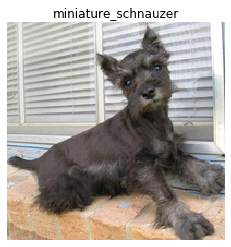

In [0]:
import matplotlib.pyplot as plt
# index of image you want to preview
index = 3

to_image = transforms.Compose([ transforms.ToPILImage() ])
img_pil = to_image(validation_data[index][0])
plt.imshow(img_pil); plt.grid('off'); plt.axis('off'); plt.title(breeds[validation_data[index][1]]);


# The Model

Loading the pretrained ResNext model.

In [0]:
import torchvision.models as models
import torch.nn as nn

# resnext = models.resnext101_32x8d(pretrained = True)
resnext = models.resnext50_32x4d(pretrained = True)

Adding Layers

In [0]:
# Define model
class DogBreedModel(nn.Module):
    def __init__(self):
        super(DogBreedModel, self).__init__()

        # Use pretrained Resnext model
        self.resnext_pt = resnext

        # Modify last layer of pretrained model
        self.resnext_pt.fc = nn.Linear(self.resnext_pt.fc.in_features, 1024)
        
        # Define additional linear layers
        self.fc2 = nn.Linear(self.resnext_pt.fc.out_features , 512)
        self.fc3 = nn.Linear(512 , 120)


    def forward(self, x):
        # Add additional linear layers
        out = self.fc2(self.resnext_pt(x))
        out = self.fc3(out)

        return out

# Data Augmentation Transformations

Source: https://pytorch.org/docs/stable/torchvision/transforms.html




In [0]:
baseline = transforms.Compose(
  [ 
    transforms.Resize((200, 200), interpolation=1),
    transforms.ToTensor()
    ])


In [0]:
from torchvision import transforms

transforms_spatial = transforms.Compose([

    # Flip image randomly horizontaly
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

    # Rotate image randomly
    transforms.RandomRotation(5),

    transforms.Resize((200, 200)),

    # Transform image to tensor
    transforms.ToTensor()
])

In [0]:
transforms_color = transforms.Compose([
    # Change brightness, contrast, saturation and hue randomly
    transforms.ColorJitter(brightness=0.1, contrast=0.1, \
                           saturation=0.1, hue=0.1),

    transforms.RandomGrayscale(p=0.1),

    # Crop image randomly
    transforms.Resize((200, 200)),

    # Transform image to tensor
    transforms.ToTensor()
])

In [0]:
transforms_all = transforms.Compose([
    
    # Change brightness, contrast, saturation and hue randomly
    transforms.ColorJitter(brightness=0.1, contrast=0.1, \
                           saturation=0.1, hue=0.1),

    transforms.RandomGrayscale(p=0.1),
    
    # Flip image randomly horizontaly
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

    # Rotate image randomly
    transforms.RandomRotation(5),

    transforms.Resize((200, 200)),

    # Transform image to tensor
    transforms.ToTensor()

])

# Training

In [0]:
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils import data


def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, n_epochs = 10):
    
   device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
   print(device)
   classifier.to(device)
   val_accuracies = []
   train_accuracies = []
   val_losses = []
   train_losses = []

   for epoch in range(n_epochs):
     running_loss = 0
     classifier.train()

     num_for_loss = 0
     for (i, (x, y)) in enumerate(trainLoader, 0):
       x, y = x.to(device), y.to(device)
       optimizer.zero_grad()
       outputs = classifier(x)

       loss = criterion(outputs, y)
       loss.backward()
       optimizer.step()
       running_loss += loss.item()

     print("({}) Loss = {}".format(epoch, running_loss/(i+1)))

     classifier.eval()
 
     num_correct = 0
     num_checked = 0
     with torch.no_grad():
       for (i, (x, y)) in enumerate(valLoader, 0):
         x, y = x.to(device), y.to(device)
         outputs = classifier(x)


         max_labels = torch.argsort(outputs.data, descending=True)[:, :5]
         y = y.reshape(y.shape[0], 1)

         num_correct += torch.eq(max_labels, y).sum().item()
         num_checked += len(max_labels)

         running_loss += loss.item()

     accuracy = round(num_correct/num_checked*100, 2)
     print("({}) Validation: accuracy = {}%".format(epoch, accuracy))
     val_accuracies.append(accuracy)
     val_losses.append(running_loss/num_checked)


     num_correct = 0
     num_checked = 0
     running_loss = 0
     with torch.no_grad():
       for (i, (x, y)) in enumerate(trainLoader, 0):
         x, y = x.to(device), y.to(device)
         outputs = classifier(x)

         max_labels = torch.argsort(outputs.data, descending=True)[:, :5]
         y = y.reshape(y.shape[0], 1)

         num_correct += torch.eq(max_labels, y).sum().item()
         num_checked += len(max_labels)

         running_loss += loss.item()

     accuracy = round(num_correct/num_checked*100, 2)
     print("({}) Training: accuracy = {}%".format(epoch, accuracy))
     train_accuracies.append(accuracy)
     train_losses.append(running_loss/num_checked)
     
  
   return (val_accuracies, train_accuracies, val_losses, train_losses)



# Visualizing the Losses and Accuracies

In [0]:
# graphing training/validation accuracies/losses
def graph(val_accuracies, train_accuracies, val_losses, train_losses):
  epochs = range(1, len(val_accuracies)+1)
  fig, ax = plt.subplots(1, 2, figsize=(20, 5))
  fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

  ax[0].plot(epochs, train_accuracies, label="training")
  ax[0].plot(epochs, val_accuracies, label="validation")
  ax[0].set(xlabel="epoch", ylabel="accuracy", title="training and validation accuracies")
  ax[0].legend()

  ax[1].plot(epochs, train_losses, label="training")
  ax[1].plot(epochs, val_losses, label="validation")
  ax[1].set(xlabel="epoch", ylabel="loss", title="training and validation losses")
  ax[1].legend()

# Results with Baseline and Custom Data Augmentation

Baseline

cuda
(0) Loss = 4.692931608973022
(0) Validation: accuracy = 53.79%
(0) Training: accuracy = 56.37%
(1) Loss = 4.3686033643716975
(1) Validation: accuracy = 81.75%
(1) Training: accuracy = 83.43%
(2) Loss = 3.7770786621364376
(2) Validation: accuracy = 88.34%
(2) Training: accuracy = 89.37%
(3) Loss = 2.944980400296759
(3) Validation: accuracy = 94.1%
(3) Training: accuracy = 94.88%
(4) Loss = 2.163845628876496
(4) Validation: accuracy = 96.5%
(4) Training: accuracy = 97.44%
(5) Loss = 1.5945817286581294
(5) Validation: accuracy = 97.45%
(5) Training: accuracy = 98.38%
(6) Loss = 1.2176513047445388
(6) Validation: accuracy = 97.69%
(6) Training: accuracy = 98.75%
(7) Loss = 0.9629597170070263
(7) Validation: accuracy = 97.93%
(7) Training: accuracy = 99.0%
(8) Loss = 0.7790426645786352
(8) Validation: accuracy = 98.18%
(8) Training: accuracy = 99.23%
(9) Loss = 0.6373347999461075
(9) Validation: accuracy = 98.2%
(9) Training: accuracy = 99.39%


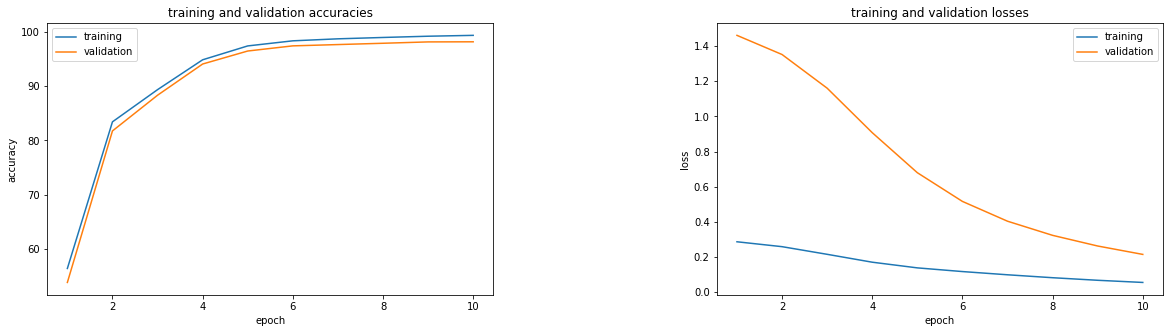

In [0]:
all_data = dog_data('./data/Images', baseline)

num_train = int(0.8 * len(all_data))
num_validation = len(all_data) - num_train
training_data, validation_data = torch.utils.data.random_split(all_data, [num_train, num_validation])


trainLoader = DataLoader(training_data, batch_size = 16, 
                         shuffle = False, num_workers = 0)

valLoader = DataLoader(validation_data, batch_size = 16, 
                         shuffle = False, num_workers = 0)


learningRate = 0.001
classifier = DogBreedModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr = learningRate)

# training model and getting training/validation accuracies/losses
results = train_model(classifier, criterion, optimizer, trainLoader, valLoader, n_epochs = 10)
graph(results[0], results[1], results[2], results[3])




Spatial

cuda
(0) Loss = 4.233685943776827
(0) Validation: accuracy = 87.65%
(0) Training: accuracy = 88.3%
(1) Loss = 2.5618638710215675
(1) Validation: accuracy = 95.49%
(1) Training: accuracy = 95.61%
(2) Loss = 1.4327542738386216
(2) Validation: accuracy = 97.27%
(2) Training: accuracy = 97.41%
(3) Loss = 1.006264854653352
(3) Validation: accuracy = 97.76%
(3) Training: accuracy = 98.14%
(4) Loss = 0.7838950926841638
(4) Validation: accuracy = 98.08%
(4) Training: accuracy = 98.75%
(5) Loss = 0.6377505279925405
(5) Validation: accuracy = 98.28%
(5) Training: accuracy = 99.1%
(6) Loss = 0.5274600899109456
(6) Validation: accuracy = 98.28%
(6) Training: accuracy = 99.24%
(7) Loss = 0.43463002145290375
(7) Validation: accuracy = 98.66%
(7) Training: accuracy = 99.42%
(8) Loss = 0.3585250194902207
(8) Validation: accuracy = 98.59%
(8) Training: accuracy = 99.58%
(9) Loss = 0.30167079047165063
(9) Validation: accuracy = 98.7%
(9) Training: accuracy = 99.62%


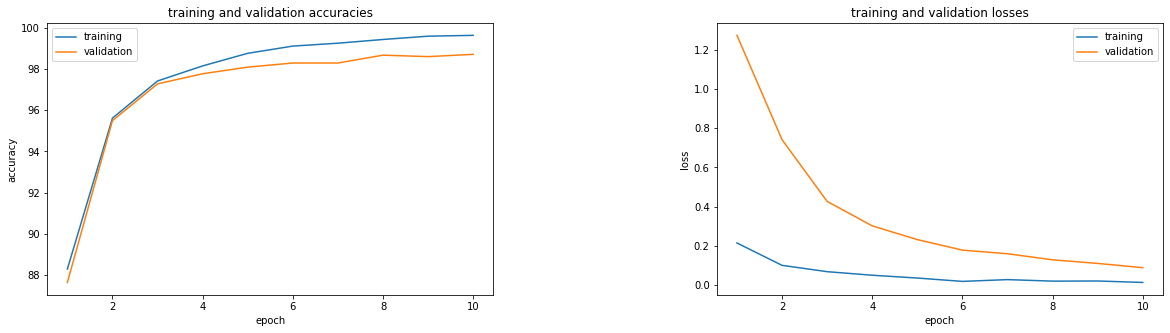

In [0]:
all_data = dog_data('./data/Images', transforms_spatial)

all_data = data.ConcatDataset([all_data, all_data_normal])

num_train = int(0.8 * len(all_data))
num_validation = len(all_data) - num_train
training_data, validation_data = torch.utils.data.random_split(all_data, [num_train, num_validation])


trainLoader = DataLoader(training_data, batch_size = 16, 
                         shuffle = False, num_workers = 0)

valLoader = DataLoader(validation_data, batch_size = 16, 
                         shuffle = False, num_workers = 0)


learningRate = 0.001
classifier_spatial = DogBreedModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier_spatial.parameters(), lr = learningRate)

# training model and getting training/validation accuracies/losses
results = train_model(classifier_spatial, criterion, optimizer, trainLoader, valLoader, n_epochs = 10)
graph(results[0], results[1], results[2], results[3])

Color

cuda
(0) Loss = 4.0778541370314
(0) Validation: accuracy = 95.42%
(0) Training: accuracy = 95.59%
(1) Loss = 1.9945348025642633
(1) Validation: accuracy = 99.6%
(1) Training: accuracy = 99.58%
(2) Loss = 0.830622032096481
(2) Validation: accuracy = 99.64%
(2) Training: accuracy = 99.8%
(3) Loss = 0.47895769415779876
(3) Validation: accuracy = 99.79%
(3) Training: accuracy = 99.89%
(4) Loss = 0.3140137737908331
(4) Validation: accuracy = 99.83%
(4) Training: accuracy = 99.92%
(5) Loss = 0.21848716843869642
(5) Validation: accuracy = 99.81%
(5) Training: accuracy = 99.95%
(6) Loss = 0.1549912208747354
(6) Validation: accuracy = 99.77%
(6) Training: accuracy = 99.95%
(7) Loss = 0.11092130033221491
(7) Validation: accuracy = 99.84%
(7) Training: accuracy = 99.97%
(8) Loss = 0.08517766979217993
(8) Validation: accuracy = 99.95%
(8) Training: accuracy = 99.97%
(9) Loss = 0.06535165289921942
(9) Validation: accuracy = 99.94%
(9) Training: accuracy = 99.98%


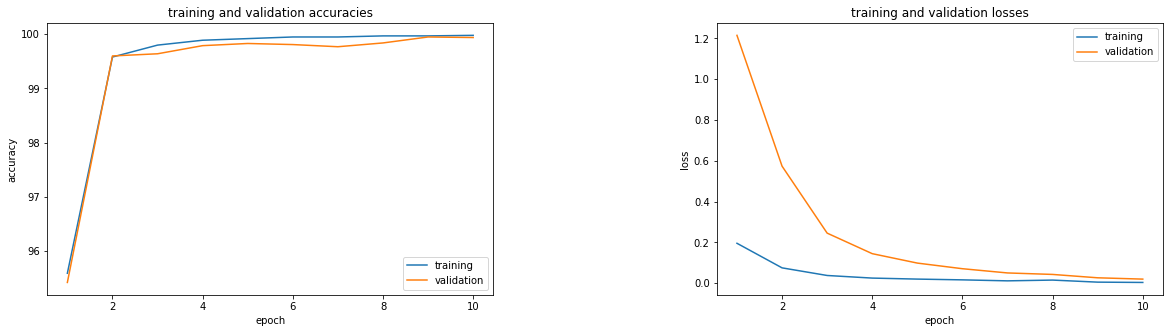

In [0]:
all_data = dog_data('./data/Images', transforms_color)

all_data = data.ConcatDataset([all_data, all_data_normal])

num_train = int(0.8 * len(all_data))
num_validation = len(all_data) - num_train
training_data, validation_data = torch.utils.data.random_split(all_data, [num_train, num_validation])


trainLoader = DataLoader(training_data, batch_size = 16, 
                         shuffle = False, num_workers = 0)

valLoader = DataLoader(validation_data, batch_size = 16, 
                         shuffle = False, num_workers = 0)


learningRate = 0.001
classifier_color = DogBreedModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier_color.parameters(), lr = learningRate)

# training model and getting training/validation accuracies/losses
results = train_model(classifier_color, criterion, optimizer, trainLoader, valLoader, n_epochs = 10)
graph(results[0], results[1], results[2], results[3])

Finding examples of correct and incorrect predictions

[(tensor([[[0.1725, 0.1294, 0.1373,  ..., 0.3804, 0.3569, 0.3020],
         [0.1294, 0.1294, 0.1294,  ..., 0.3569, 0.3255, 0.3137],
         [0.1412, 0.1373, 0.1216,  ..., 0.3216, 0.3020, 0.3137],
         ...,
         [0.1020, 0.0980, 0.1216,  ..., 0.5686, 0.5059, 0.4941],
         [0.1804, 0.0902, 0.0824,  ..., 0.5882, 0.5451, 0.5020],
         [0.2745, 0.1373, 0.0667,  ..., 0.5882, 0.5412, 0.5176]],

        [[0.1373, 0.0941, 0.1020,  ..., 0.2980, 0.2627, 0.2157],
         [0.1216, 0.1216, 0.1216,  ..., 0.2667, 0.2235, 0.2157],
         [0.1490, 0.1451, 0.1294,  ..., 0.2314, 0.2000, 0.2157],
         ...,
         [0.0627, 0.0627, 0.0941,  ..., 0.4980, 0.4353, 0.4235],
         [0.1412, 0.0549, 0.0549,  ..., 0.5216, 0.4745, 0.4314],
         [0.2235, 0.0980, 0.0392,  ..., 0.5451, 0.4980, 0.4549]],

        [[0.1098, 0.0667, 0.0745,  ..., 0.2745, 0.2392, 0.1922],
         [0.0941, 0.0863, 0.0824,  ..., 0.2471, 0.2039, 0.1961],
         [0.1176, 0.1059, 0.0863,  ..., 0.2118, 0.1804, 

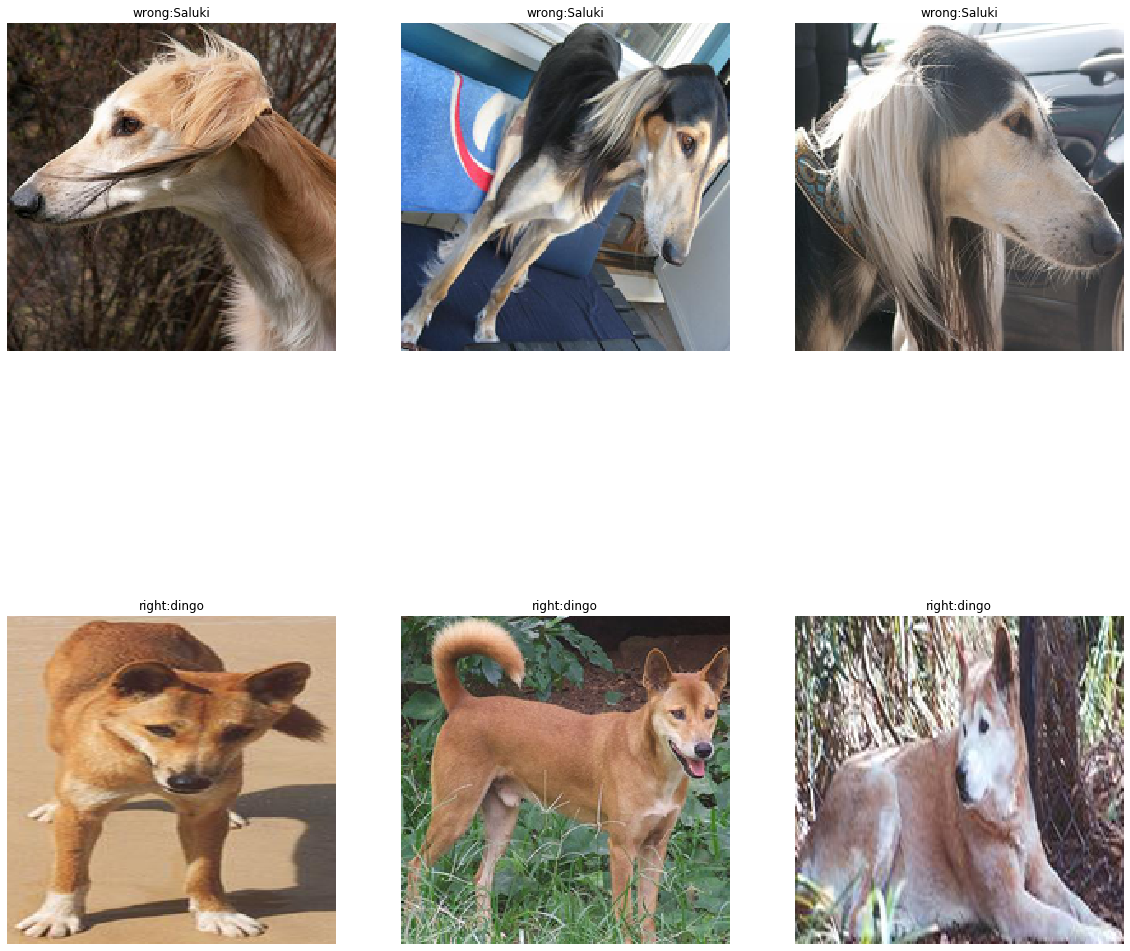

In [0]:
correct = []
wrong = []
num_correct = 0
num_wrong = 0
for i in range(len(all_data_normal)):
  if num_correct < 3 or num_wrong < 3:
    preds = classifier_color(all_data_normal[i][0].unsqueeze(0).to("cuda"))
    y = all_data_normal[i][1]
    
    max_labels = torch.argsort(preds.data, descending=True)[:, :5]
    y = y.reshape(y.shape, 1)

    isCorrect =  torch.eq(max_labels, y).sum().item()

    if isCorrect > 0 and num_correct < 3:
       correct.append([all_data_normal[i], max_labels])
       num_correct += 1
    if isCorrect == 0 and num_wrong < 3:
       wrong.append([all_data_normal[i], max_labels])
       num_wrong += 1
  else: break

fig, axs = plt.subplots(2, 3, figsize=(20, 20))
axs = axs.ravel()
indices = [0, 1, 2, 0, 1, 2]
on_wrong = True
for i, ax in zip(indices, axs):
  if on_wrong:
    img_pil = to_image(wrong[i][0][0])
    ax.imshow(img_pil)
    ax.grid('off')
    ax.axis('off')
    ax.set_title('wrong:' + breeds[wrong[i][0][1]])
    if i == 2: on_wrong = False
  else:
    img_pil = to_image(correct[i][0][0])
    ax.imshow(img_pil)
    ax.grid('off')
    ax.axis('off')
    ax.set_title('right:' + breeds[correct[i][0][1]])

 


plt.show()

Combination of Color and Spatial

cuda
(0) Loss = 4.033252797738456
(0) Validation: accuracy = 95.85%
(0) Training: accuracy = 95.67%
(1) Loss = 1.9090785260798284
(1) Validation: accuracy = 98.74%
(1) Training: accuracy = 99.04%
(2) Loss = 0.8266288095214508
(2) Validation: accuracy = 98.99%
(2) Training: accuracy = 99.23%
(3) Loss = 0.5351968482498757
(3) Validation: accuracy = 99.05%
(3) Training: accuracy = 99.4%
(4) Loss = 0.40536000377582737
(4) Validation: accuracy = 99.3%
(4) Training: accuracy = 99.49%
(5) Loss = 0.3328368541132025
(5) Validation: accuracy = 99.11%
(5) Training: accuracy = 99.62%
(6) Loss = 0.2774351768492494
(6) Validation: accuracy = 99.26%
(6) Training: accuracy = 99.64%
(7) Loss = 0.23639383398003666
(7) Validation: accuracy = 98.98%
(7) Training: accuracy = 99.69%
(8) Loss = 0.20664510745609466
(8) Validation: accuracy = 98.98%
(8) Training: accuracy = 99.69%
(9) Loss = 0.182867005757039
(9) Validation: accuracy = 98.97%
(9) Training: accuracy = 99.72%


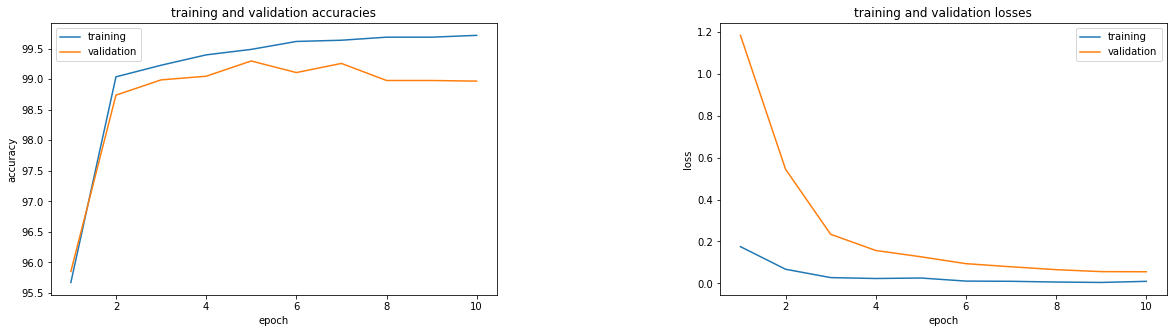

In [0]:
all_data = dog_data('./data/Images', transforms_all)
all_data = data.ConcatDataset([all_data, all_data_normal])

num_train = int(0.8 * len(all_data))
num_validation = len(all_data) - num_train
training_data, validation_data = torch.utils.data.random_split(all_data, [num_train, num_validation])


trainLoader = DataLoader(training_data, batch_size = 16, 
                         shuffle = False, num_workers = 0)

valLoader = DataLoader(validation_data, batch_size = 16, 
                         shuffle = False, num_workers = 0)


learningRate = 0.001
classifier_all = DogBreedModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier_all.parameters(), lr = learningRate)

# training model and getting training/validation accuracies/losses
results = train_model(classifier_all, criterion, optimizer, trainLoader, valLoader, n_epochs = 10)
graph(results[0], results[1], results[2], results[3])